<a href="https://colab.research.google.com/github/HagerArafat/XAI-Adult/blob/main/XAI_Adult_Income_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load Adult Income Dataset**

In [ ]:
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

columns = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]

df = pd.read_csv(url, names=columns, na_values=" ?", skipinitialspace=True)

df.head()


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# **Data description**

In [ ]:
print(df.info())

print(df.describe())

print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None
                age        fnlwgt  education_num  capital_gain  capital_loss  \
count  3

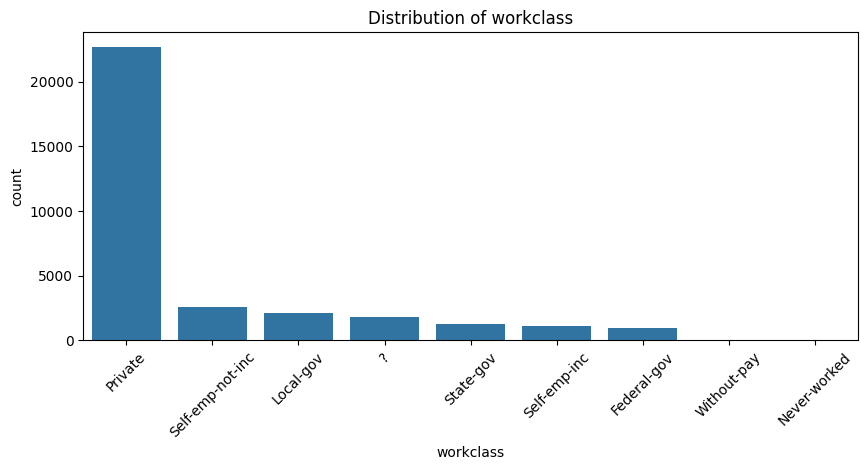

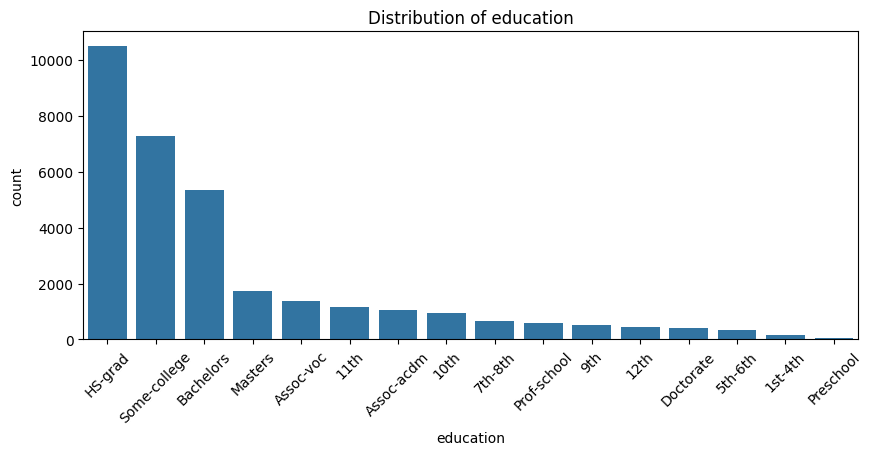

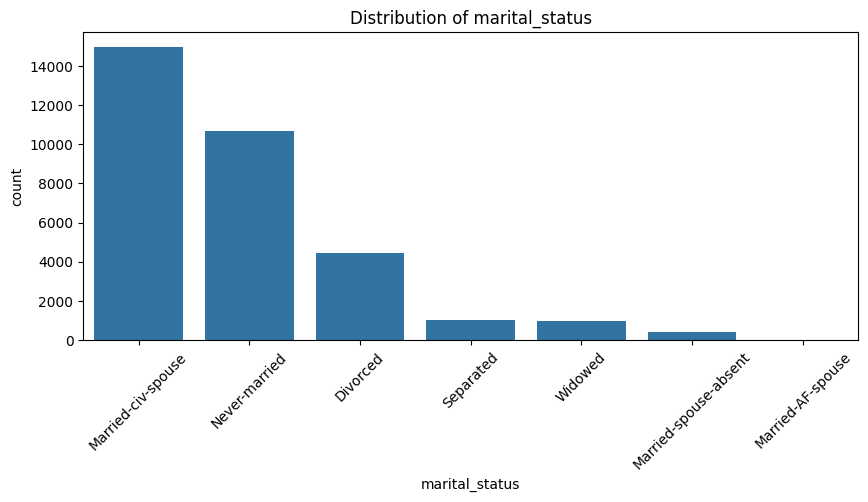

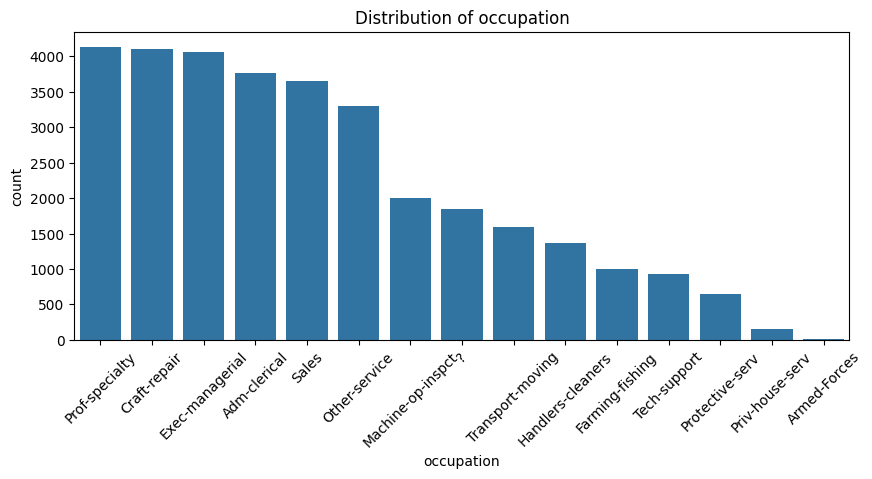

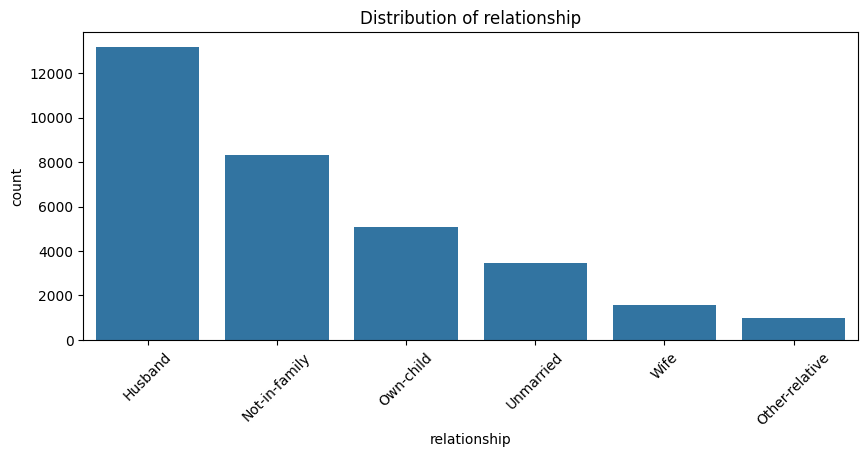

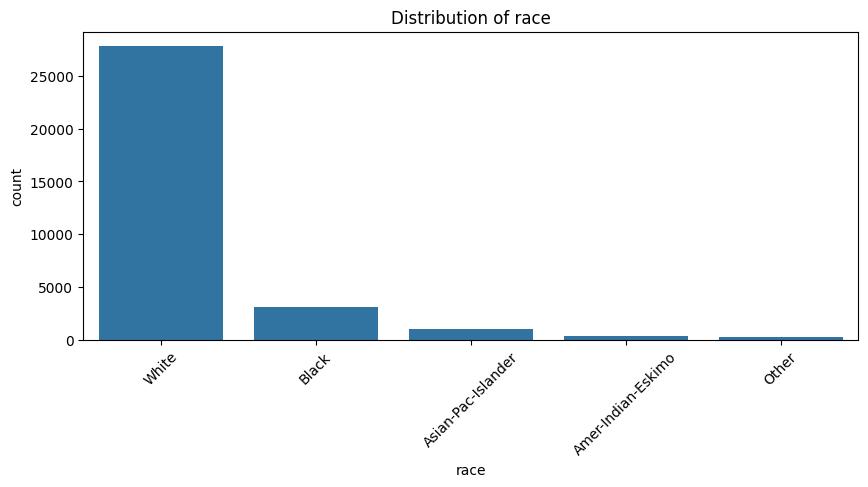

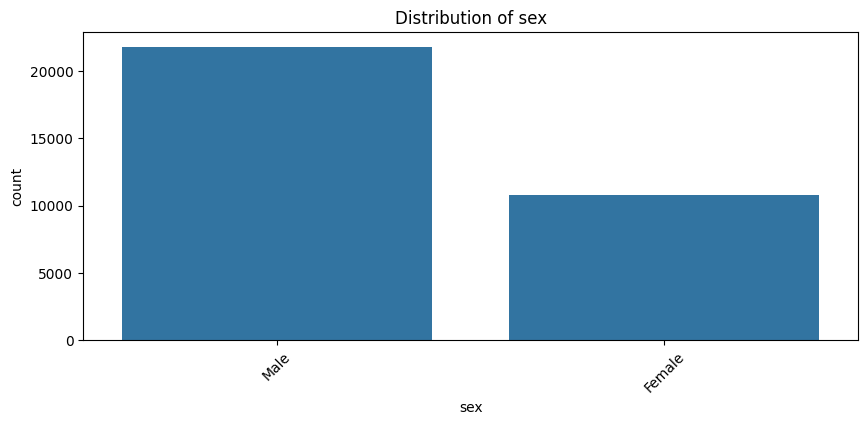

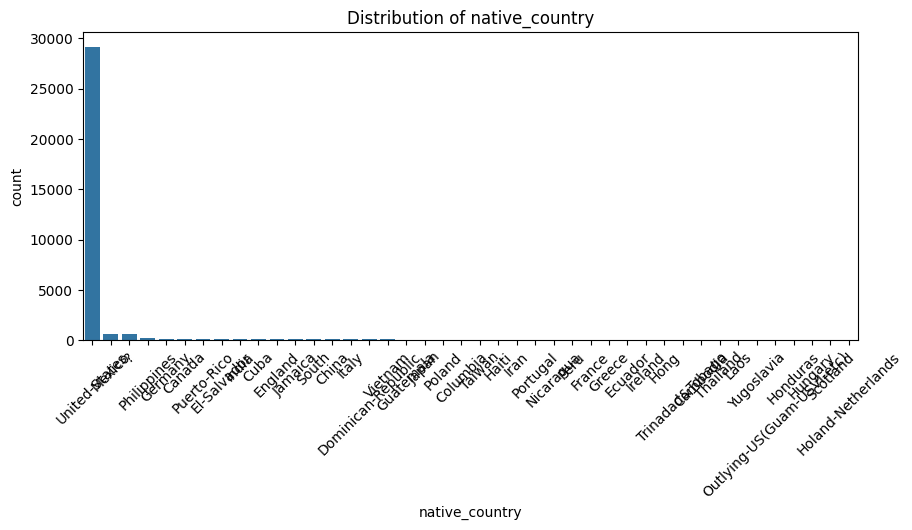

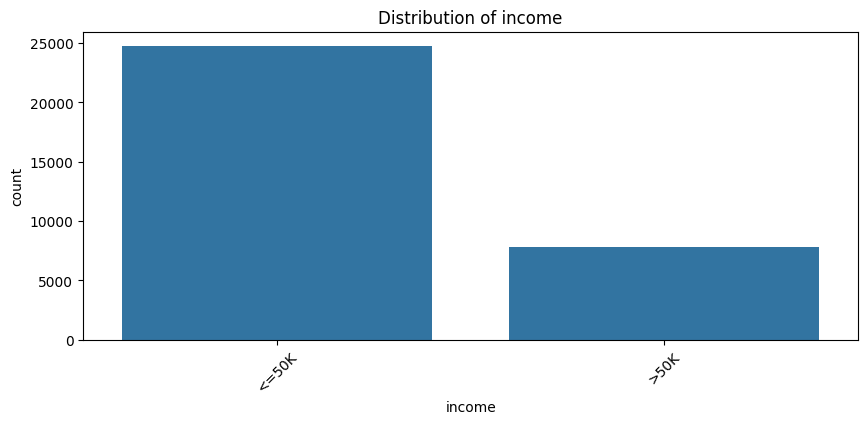

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

categorical_features = df.select_dtypes(include='object').columns

for col in categorical_features:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()


# **Preprocessing**

**Label** **Encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()

le = LabelEncoder()

for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])

df_encoded.head()


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


# **Training(Random Forest)**

In [ ]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('income', axis=1)
y = df_encoded['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (26048, 14)
Test shape: (6513, 14)


Accuracy: 0.8616612927990174

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      4942
           1       0.75      0.64      0.69      1571

    accuracy                           0.86      6513
   macro avg       0.82      0.79      0.80      6513
weighted avg       0.86      0.86      0.86      6513



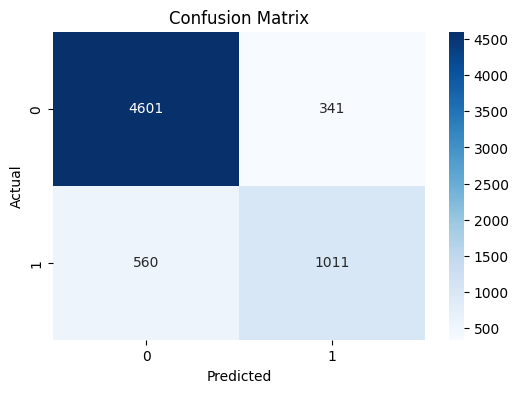

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# **XAI**

**LIME**

In [ ]:
!pip install lime

import lime
import lime.lime_tabular
import numpy as np

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns,
    class_names=['<=50K', '>50K'],
    mode='classification'
)

i = 0
sample = X_test.iloc[i]

exp = explainer.explain_instance(
    data_row=sample,
    predict_fn=model.predict_proba
)

exp.show_in_notebook(show_all=False)


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

# **SHAP**

PermutationExplainer explainer: 101it [01:01,  1.55it/s]
<ipython-input-9-2ed63600870d>:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, sample_X_test, feature_names=X.columns)


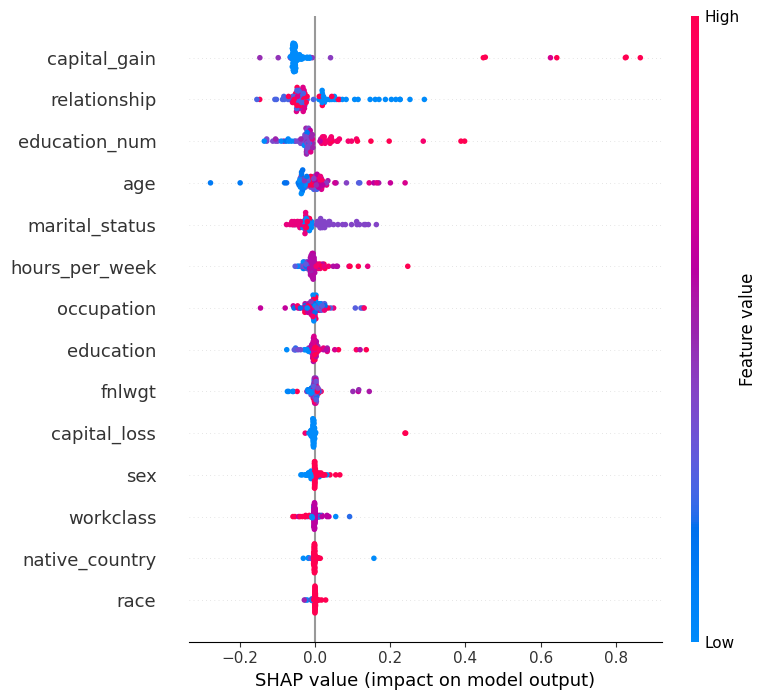

In [ ]:
!pip install shap
import shap
shap.initjs()

sample_X_test = X_test.iloc[:100]

explainer = shap.Explainer(model.predict, sample_X_test)
shap_values = explainer(sample_X_test)

shap.summary_plot(shap_values.values, sample_X_test, feature_names=X.columns)



## **Partial Dependence Plot** **1D**

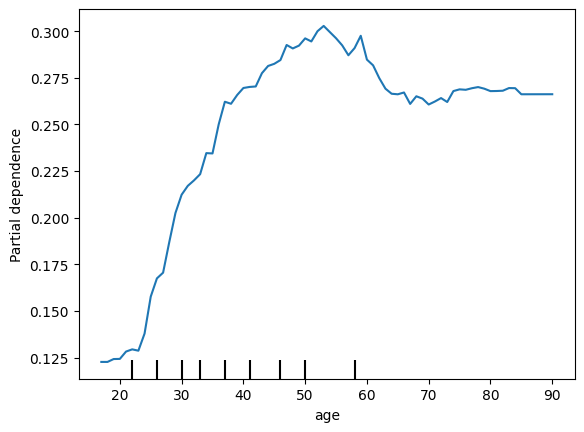

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

features = ['age']

PartialDependenceDisplay.from_estimator(
    estimator=model,
    X=X_test,
    features=features,
    feature_names=X.columns,
    target=1,
    grid_resolution=100,
)

import matplotlib.pyplot as plt
plt.show()


# **2D**

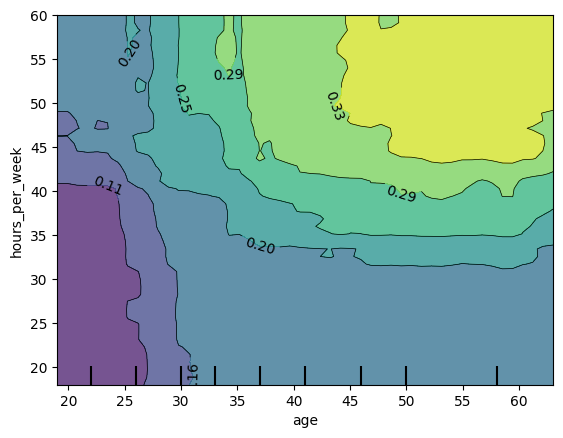

In [ ]:
features = [('age', 'hours_per_week')]

PartialDependenceDisplay.from_estimator(
    estimator=model,
    X=X_test,
    features=features,
    feature_names=X.columns,
    target=1,
    grid_resolution=50,
)

plt.show()
